In [0]:
!pwd
!wget http://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
!tar -xf fishRecognition_GT.tar
!ls

/content
--2019-03-05 03:42:21--  http://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510912000 (487M) [application/x-tar]
Saving to: ‘fishRecognition_GT.tar’

fishRecognition_GT. 100%[===================>] 487.24M  16.4MB/s    in 30s     

2019-03-05 03:42:52 (16.0 MB/s) - ‘fishRecognition_GT.tar’ saved [510912000/510912000]

tar: A lone zero block at 997875
fish_image  fishRecognition_GT.tar  mask_image	sample_data


In [0]:
#@title
base_path='/content/fish_image'
dir_list = os.listdir(base_path)
x_train_filenames = []
y_train_filenames = []
labels=[]
for filedir in dir_list:
  filedir=os.path.join(base_path,filedir)
  for file in os.listdir(filedir):
    filepath=os.path.join(base_path,filedir,file)
    x_train_filenames.append(filepath)
    y_train_filenames.append(filepath.replace('fish','mask'))
    labels.append(os.path.basename(filedir))
    
print(labels[1])
print(len(labels))

In [0]:
import os
os.chdir('/content')
!ls
#!pip install keras-metrics
#!rm -f /content/fishRecognition_GT.tar

fish_image  fishRecognition_GT.tar  mask_image	sample_data


In [0]:
import os
import glob
import zipfile
import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
from tensorflow.python.keras.layers import Add,add,SeparableConv2D
#通用
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.models import Model
from PIL import Image
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
import random as rn
#可复现代码
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2)
rn.seed(1)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# 限制内存占用
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
# competition_name=('/content')
# img_dir = os.path.join(competition_name, "fish_image",'fish_01')
# label_dir = os.path.join(competition_name, "mask_image",'mask_01')
# df_train = pd.read_csv(os.path.join(competition_name, 'test.csv'))
# ids_train = df_train['file_name'].map(lambda s: s.split('.')[0])
# x_train_filenames = []
# y_train_filenames = []
# for img_id in ids_train:
#   x_train_filenames.append(os.path.join(img_dir, "fish_0{}.png".format(img_id)))
#   y_train_filenames.append(os.path.join(label_dir, "mask_0{}.png".format(img_id)))

base_path='/content/fish_image'
dir_list = os.listdir(base_path)
x_train_filenames = []
y_train_filenames = []
labels=[]
for filedir in dir_list:
  filedir=os.path.join(base_path,filedir)
  for file in os.listdir(filedir):
    filepath=os.path.join(base_path,filedir,file)
    x_train_filenames.append(filepath)
    y_train_filenames.append(filepath.replace('fish','mask'))
    labels.append(os.path.basename(filedir))


x_train_filenames, x_other_filenames, y_train_filenames, y_other_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames = \
                    train_test_split(x_other_filenames, y_other_filenames, test_size=0.5, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)
# encoder = LabelEncoder()
# encoded_Y = encoder.fit_transform(labels)
# y = np.array(encoded_Y)
# y_train = np_utils.to_categorical(y_train)
# y_test = np_utils.to_categorical(y_test)



print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 21896
Number of validation examples: 2737
Number of test examples: 2737


In [0]:
x_train_filenames[:5]

['/content/fish_image/fish_04/fish_003759805985_21102.png',
 '/content/fish_image/fish_01/fish_004360997106_18898.png',
 '/content/fish_image/fish_01/fish_003433105293_20691.png',
 '/content/fish_image/fish_01/fish_003434645293_24938.png',
 '/content/fish_image/fish_01/fish_004211116888_14792.png']

In [0]:
y_train_filenames[:5]

['/content/mask_image/mask_04/mask_003759805985_21102.png',
 '/content/mask_image/mask_01/mask_004360997106_18898.png',
 '/content/mask_image/mask_01/mask_003433105293_20691.png',
 '/content/mask_image/mask_01/mask_003434645293_24938.png',
 '/content/mask_image/mask_01/mask_004211116888_14792.png']

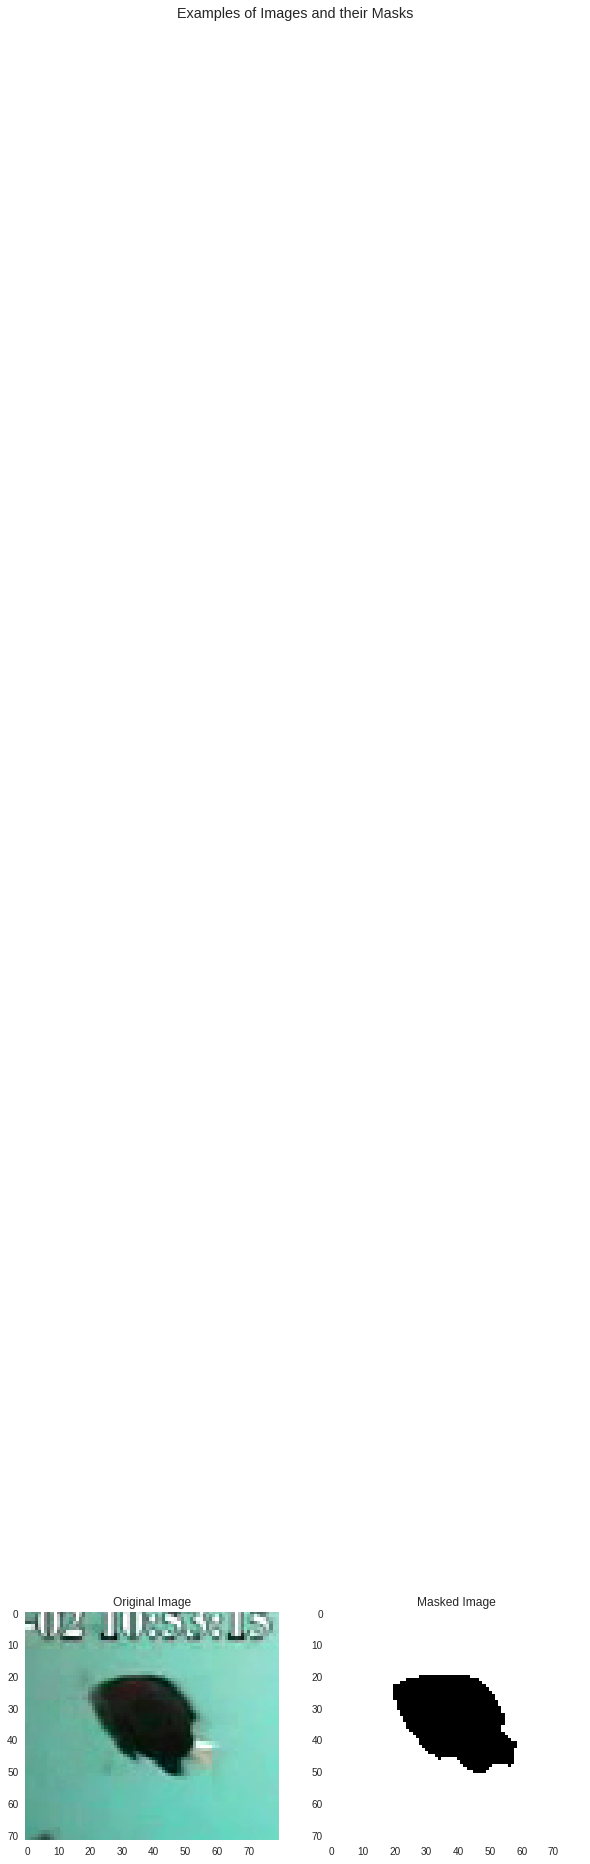

In [0]:
display_num = 10

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 50))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
#   example_labels = Image.open(y_pathname)
#   label_vals = np.unique(example_labels)
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(mpimg.imread(y_pathname))
#   plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
img_shape = (128, 128, 3)
batch_size=6

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  # These are png images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_png(label_img_str)
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (fish) or not (background). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)
def conv_block1(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block1(input_tensor, num_filters):
  encoder = conv_block1(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block2(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder
#分离残差卷积
def conv_block(input_tensor, num_filters):
  encoder_1 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder_2 = layers.BatchNormalization()(encoder_1)
  encoder_3 = layers.Activation('relu')(encoder_2)
  encoder_4 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(encoder_3)
  encoder_5 = layers.BatchNormalization()(encoder_4)
  encoder_6 = layers.Activation('relu')(encoder_5)
  encoder_7 = layers.Conv2D(num_filters, (1, 1),padding='same')(input_tensor)
  encoder = layers.add([encoder_7,encoder_3])
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder_1 = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
  decoder_2 = layers.concatenate([concat_tensor, decoder_1], axis=-1)
  decoder_3 = layers.BatchNormalization()(decoder_2)
  concat_4 = layers.Activation('relu')(decoder_3)
  decoder_5 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(concat_4)
  decoder_6 = layers.BatchNormalization()(decoder_5)
  decoder_7 = layers.Activation('relu')(decoder_6)
  decoder_8 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder_7)
  decoder_9 = layers.BatchNormalization()(decoder_8)
  decoder_10 = layers.Activation('relu')(decoder_9)
  sp = layers.Conv2D(num_filters, (1, 1),padding='same')(concat_4)
  decoder_11 = layers.add([sp,decoder_10])
  return decoder_11

def decoder_block1(input_tensor, concat_tensor, num_filters):
  decoder_1 = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
  decoder_2 = layers.concatenate([concat_tensor, decoder_1], axis=-1)
  decoder_3 = layers.BatchNormalization()(decoder_2)
  concat_4 = layers.Activation('relu')(decoder_3)
  return concat_4
#原始unet
inputs1 = layers.Input(shape=img_shape)
# 256

# encoder0_pool, encoder0 = encoder_block1(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block1(inputs1, 64)
# 64

encoder2_pool, encoder2 = encoder_block1(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block1(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block1(encoder3_pool, 512)
# 8

center = conv_block1(encoder4_pool, 1024)
# center

decoder4 = decoder_block2(center, encoder4, 512)
# 16

decoder3 = decoder_block2(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block2(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block2(decoder2, encoder1, 64)
# 128

# decoder0 = decoder_block2(decoder1, encoder0, 32)
# 256

outputs1 = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder1)


model1 = models.Model(inputs=[inputs1], outputs=[outputs1])
#model1.summary()
#分离残差卷积
inputs = layers.Input(shape=img_shape)
# 256

# encoder0_pool, encoder0 = encoder_block(inputs, 32)
# # 128

encoder1_pool, encoder1 = encoder_block(inputs, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block1(decoder2, encoder1, 64)
# 128

# decoder0 = decoder_block(decoder1, encoder0, 32)
# # 256

outputs = layers.SeparableConv2D(1, (1, 1), activation='sigmoid')(decoder1)
model = models.Model(inputs=[inputs], outputs=[outputs])
#model.summary()
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
def bce_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred)
    return loss
#性能计算
from keras import backend as K

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

from keras.callbacks import Callback

#own mothed
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[precision,recall,f1])
#unet
model1.compile(optimizer='adam', loss=bce_loss, metrics=[precision,recall,f1])

model.summary()

save_model1_path = '/content/model1-ep{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.hdf5'
save_model_path = '/content/model-ep{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10,verbose=1, min_lr=0.0001)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 64) 283         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 128, 128, 64) 256         separable_conv2d[0][0]           
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 256         input_2[0][0]          

In [0]:
#分离残差卷积
def conv_block(input_tensor, num_filters):
  encoder_1 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder_2 = layers.BatchNormalization()(encoder_1)
  encoder_3 = layers.Activation('relu')(encoder_2)
  encoder_4 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(encoder_3)
  encoder_5 = layers.BatchNormalization()(encoder_4)
  encoder_6 = layers.Activation('relu')(encoder_5)
  encoder_7 = layers.Conv2D(num_filters, (1, 1),padding='same')(input_tensor)
  encoder = layers.add([encoder_7,encoder_3])
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder_1 = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
  decoder_2 = layers.concatenate([concat_tensor, decoder_1], axis=-1)
  decoder_3 = layers.BatchNormalization()(decoder_2)
  concat_4 = layers.Activation('relu')(decoder_3)
  decoder_5 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(concat_4)
  decoder_6 = layers.BatchNormalization()(decoder_5)
  decoder_7 = layers.Activation('relu')(decoder_6)
  decoder_8 = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder_7)
  decoder_9 = layers.BatchNormalization()(decoder_8)
  decoder_10 = layers.Activation('relu')(decoder_9)
  sp = layers.Conv2D(num_filters, (1, 1),padding='same')(concat_4)
  decoder_11 = layers.add([sp,decoder_10])
  return decoder_11

def decoder_block1(input_tensor, concat_tensor, num_filters):
  decoder_1 = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(input_tensor)
  decoder_2 = layers.concatenate([concat_tensor, decoder_1], axis=-1)
  decoder_3 = layers.BatchNormalization()(decoder_2)
  concat_4 = layers.Activation('relu')(decoder_3)
  return concat_4
#model1.summary()
#分离残差卷积
inputs = layers.Input(shape=img_shape)
# 256

# encoder0_pool, encoder0 = encoder_block(inputs, 32)
# # 128

encoder1_pool, encoder1 = encoder_block(inputs, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block1(decoder2, encoder1, 64)
# 128

# decoder0 = decoder_block(decoder1, encoder0, 32)
# # 256

outputs = layers.SeparableConv2D(1, (1, 1), activation='sigmoid')(decoder1)
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

In [0]:
#@title
#bce_loss
model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[dice_loss,'acc'])

#model.summary()

save_model_path = '/tmp/bce_weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)


In [0]:
#@title
#dice_loss
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss,'acc'])

#model.summary()

save_model_path = '/content/dice_weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
img_shape = (28, 28, 3)
batch_size = 32
epochs = 5
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[early_stop,reduce_lr,cp])

In [0]:
history1 = model1.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[early_stop,reduce_lr])

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import os
os.chdir('/tmp/')
!ls
# Create & upload a text file.
uploaded = drive.CreateFile({'unet': 'weight.hdf5'})
uploaded.SetContentFile('weights.hdf5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
loss = history.history['bce_dice_loss']
val_loss = history.history['val_bce_dice_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
loss1 = history1.history['bce_dice_loss']
val_loss1 = history1.history['val_bce_dice_loss']

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Training Acc')
plt.plot(epochs_range, val_acc1, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)

model = models.load_model('/content/model-ep010-train_loss0.747-val_loss0.743.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

[[[0.30588236 0.59607846 0.56078434]
  [0.30842528 0.6011642  0.56332725]
  [0.31096816 0.60508585 0.56703436]
  ...
  [0.48998165 0.8664523  0.81939346]
  [0.48743877 0.86390936 0.81685054]
  [0.48627454 0.86274517 0.81568635]]

 [[0.29754904 0.5981618  0.5545344 ]
  [0.30279374 0.60054576 0.55977905]
  [0.3068015  0.6030025  0.56433254]
  ...
  [0.48801225 0.8561495  0.81325734]
  [0.48682025 0.8549575  0.81206536]
  [0.48627454 0.85441184 0.8115197 ]]

 [[0.2901961  0.6        0.54901963]
  [0.29782477 0.6        0.5566483 ]
  [0.30312502 0.6011642  0.56194854]
  ...
  [0.48651963 0.8475491  0.8080883 ]
  [0.48651963 0.8475491  0.8080883 ]
  [0.48651963 0.8475491  0.8080883 ]]

 ...

 [[0.2794118  0.13725491 0.02071078]
  [0.31525066 0.16800801 0.03326632]
  [0.35028917 0.1995979  0.0556813 ]
  ...
  [0.78449184 0.7336694  0.56476146]
  [0.7531825  0.701327   0.5334521 ]
  [0.7388481  0.6865196  0.51911765]]

 [[0.3627451  0.20392159 0.04779412]
  [0.37561852 0.21170919 0.04684054]


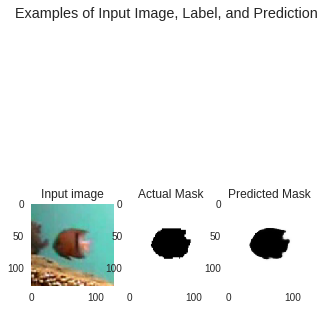

In [0]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(5, 20))
for i in range(1):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.title("Input image")
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

In [0]:
  import argparse
  import time
  import json
  test_cfg = {
      'resize': [512, 512],
      'scale': 1 / 255.,
  }
  test_preprocessing_fn = functools.partial(_augment, **test_cfg)
  test_ds = get_baseline_dataset(x_test_filenames, 
                                 y_test_filenames,
                                 preproc_fn=test_preprocessing_fn,
                                 batch_size=1)
  data_aug_iter = test_ds.make_one_shot_iterator() 
  next_element = data_aug_iter.get_next()  
  for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    plt.figure(figsize=(10, 10))
    img = batch_of_imgs[0]
    start_time = time.time()
    predicted_label = model.predict(batch_of_imgs)[0]
    duration = time.time() - start_time
    print('Generated segmentations in %s mseconds -- %s FPS' % (duration*1000, 1.0/duration))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Input image")
    plt.subplot(1,3,2)
    plt.imshow(label[0, :, :, 0])
    plt.title("Actual Mask")
    plt.subplot(1,3,3)
    plt.imshow(predicted_label[:, :, 0])
    plt.title("Predicted Mask")
  